
# Bell‑202 FSK: C `demodFSK()` Test
1) Generate FSK (mark=1200 Hz, space=2200 Hz) and quantize to 12‑bit ADC samples.  
2) Compile **`demod_fsk.c`** into a shared library.  
3) Call `demodFSK(uint16_t)` per sample and plot **input vs output**.
4) Call `bitstreamReconstruction(float)` and `retrieveBitstream()` to get the UART frame.


In [8]:
# Build libdemod.so from demod_fsk.c and fir_coefs.h
!gcc -std=c11 -O1 -march=native -fPIC -shared demod_fsk.c -o libdemod.so -lm

print("Compiled libdemod.so")

Compiled libdemod.so


In [9]:
import numpy as np
import ctypes
from matplotlib import pyplot as plt

print("Libraries loaded")

Libraries loaded


In [10]:
# Load the shared library
libdemod = ctypes.CDLL('./libdemod.so')

# Define function signature: float demodFSK(uint16_t adc_value)
libdemod.demodFSK.argtypes = (ctypes.c_uint16,)
libdemod.demodFSK.restype = ctypes.c_float

print("demodFSK() loaded")

demodFSK() loaded


In [11]:
# --- TP3 Parameters ---
Fs       = 12000        # Sampling frequency [Hz]
bps      = 1200         # Bit rate [bits/s]
F_MARK   = 1200         # '1' → 1200 Hz
F_SPACE  = 2200         # '0' → 2200 Hz
amp      = 1.0          # Amplitude (normalized)

# --- Bitstream (from PDF Fig. 7) ---
# bits_str = "110111111111101010101011"
# bits_str = "110111111111111100101010101"  # any pattern
data_str = "00110001 00110010 00110011 00110100 00110101 00110110 00110111 00111000 00111001 00110000 01000001 01000010 01000011 01000100 01000101 01000110 01000111 01001000 01001001 01001010 01001011 01001100 01001101 01001110 01001111 01010000 01010001 01010010 01010011 01010100 01010101 01010110 01010111 01011000 01011001 01011010 00110001 00110010 00110011 00110100 00110101 00110110 00110111 00111000 00111001 00110000 01000001 01000010 01000011 01000100 01000101 01000110 01000111 01001000 01001001 01001010 01001011 01001100 01001101 01001110 01001111 01010000 01010001 01010010 01010011 01010100 01010101 01010110 01010111 01011000 01011001 01011010"

def binary_string_to_uart_frames(binary_str: str) -> str:
    """
    Convert a space-separated binary string (8-bit groups) into UART 8O1 frames.
    Each frame: 1 start bit (0), 8 data bits (LSB first), 1 odd parity bit, 1 stop bit (1).
    
    Returns a single string with all frames concatenated without spaces.
    """
    # Split into 8-bit groups and filter out empty strings
    bytes_bin = [b for b in binary_str.split() if b]
    
    frames = []
    
    for byte_bin in bytes_bin:
        if len(byte_bin) != 8:
            raise ValueError(f"Each byte must be 8 bits, got: {byte_bin}")
        
        # Reverse to send LSB first
        data_bits = list(byte_bin[::-1])
        
        # Count 1s in data bits
        ones_count = sum(1 for bit in data_bits if bit == '1')
        # Odd parity: total 1s (data + parity) must be odd
        parity_bit = '0' if ones_count % 2 == 1 else '1'
        
        # Build frame: start + data (LSB first) + parity + stop
        frame = '0' + ''.join(data_bits) + parity_bit + '1'
        frames.append(frame)
    
    # Join all frames without any separator
    return ''.join(frames)

bits_str = binary_string_to_uart_frames(data_str)

print(f"Bitstream: {bits_str[:1024]}")

Bitstream: 010001100010010011000101100110011000101100010101011001100110110011011101100010000111000101001110011000001100110100000101100100001011011000010010001000101101010001001001100010010111000101100001001011010010010010010100100101101001011000110010010101100101100111001011011110010010000010101101000101001001001010010110010101100010101001010101010110011010101101110101001000011010010100110101100101101011010001100010010011000101100110011000101100010101011001100110110011011101100010000111000101001110011000001100110100000101100100001011011000010010001000101101010001001001100010010111000101100001001011010010010010010100100101101001011000110010010101100101100111001011011110010010000010101101000101001001001010010110010101100010101001010101010110011010101101110101001000011010010100110101100101101011


In [12]:
# Samples per bit
Ns = int(round(Fs / bps))           # → 10
N  = Ns * len(bits_str)             # Total samples
t  = np.arange(N) / Fs              # Time vector [s]

# Frequency per sample
bits = np.array([b == '1' for b in bits_str], dtype=bool)
freqs = np.where(np.repeat(bits, Ns), F_MARK, F_SPACE)

# Continuous phase FSK
phase = np.cumsum(2 * np.pi * freqs / Fs)
fsk_signal = amp * np.sin(phase)

# Quantize to 12-bit ADC (0–4095)
adc_bits = 12
adc_max = (1 << adc_bits) - 1
adc_signal = np.round((fsk_signal + 1.0) * 0.5 * adc_max).astype(np.uint16)

print(f"Generated {N} samples ({len(bits_str)} bits, {Ns} samples/bit)")

Generated 7920 samples (792 bits, 10 samples/bit)


In [13]:
# Output buffer
d_output = np.zeros(N, dtype=np.float32)

print("Running demodFSK() on each ADC sample...")
for i in range(N):
    d_output[i] = libdemod.demodFSK(ctypes.c_uint16(adc_signal[i]))

print("Done.")

Running demodFSK() on each ADC sample...
Done.


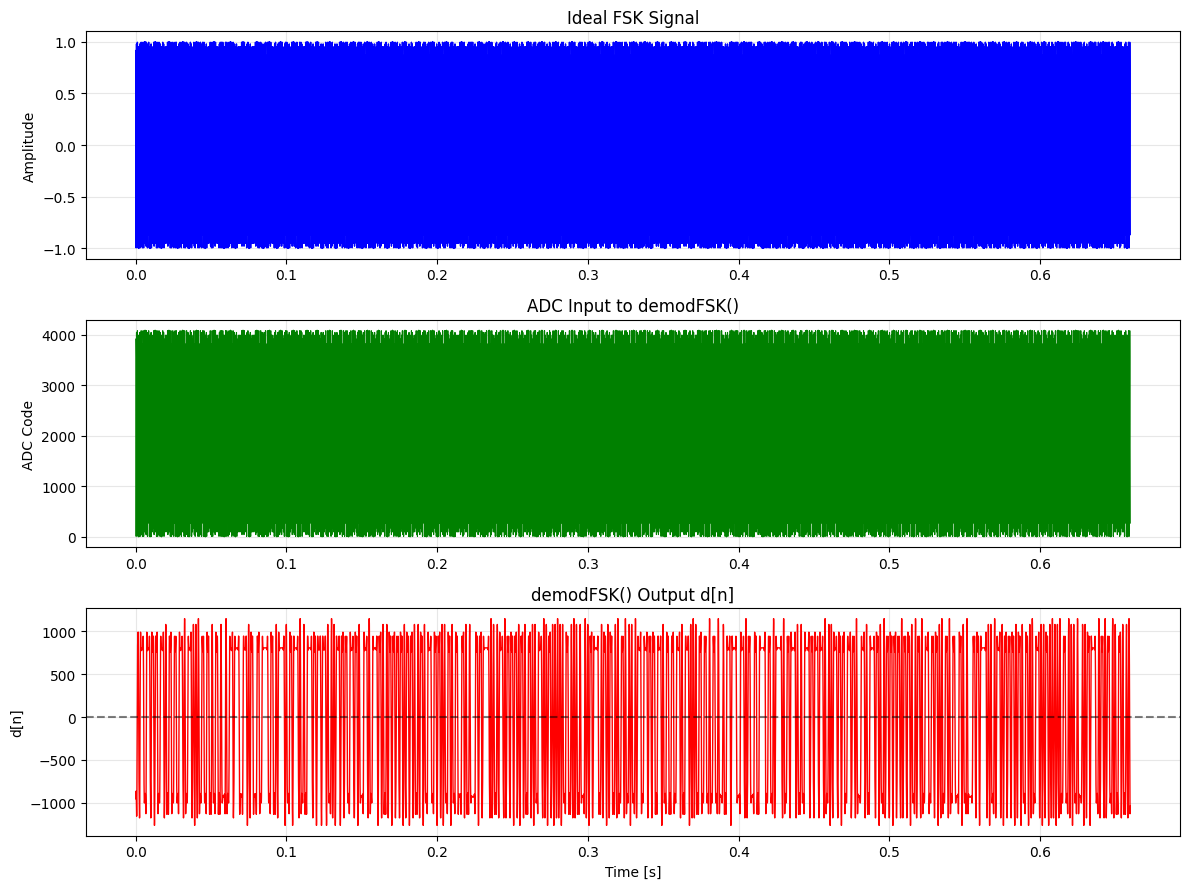

bitstreamReconstruction() and UART functions loaded
Running bitstreamReconstruction() on each d[n]...
UART Frame 1: 0 0 1 0 1 1 0 1 0 1 1
UART Frame 2: 0 1 0 0 0 1 1 0 0 0 1
UART Frame 3: 0 0 1 0 0 1 1 0 0 0 1
UART Frame 4: 0 1 1 0 0 1 1 0 0 1 1
UART Frame 5: 0 0 0 1 0 1 1 0 0 0 1
UART Frame 6: 0 1 0 1 0 1 1 0 0 1 1
UART Frame 7: 0 0 1 1 0 1 1 0 0 1 1
UART Frame 8: 0 1 1 1 0 1 1 0 0 0 1
UART Frame 9: 0 0 0 0 1 1 1 0 0 0 1
UART Frame 10: 0 1 0 0 1 1 1 0 0 1 1
UART Frame 11: 0 0 0 0 0 1 1 0 0 1 1
UART Frame 12: 0 1 0 0 0 0 0 1 0 1 1
UART Frame 13: 0 0 1 0 0 0 0 1 0 1 1
UART Frame 14: 0 1 1 0 0 0 0 1 0 0 1
UART Frame 15: 0 0 0 1 0 0 0 1 0 1 1
UART Frame 16: 0 1 0 1 0 0 0 1 0 0 1
UART Frame 17: 0 0 1 1 0 0 0 1 0 0 1
UART Frame 18: 0 1 1 1 0 0 0 1 0 1 1
UART Frame 19: 0 0 0 0 1 0 0 1 0 1 1
UART Frame 20: 0 1 0 0 1 0 0 1 0 0 1
UART Frame 21: 0 0 1 0 1 0 0 1 0 0 1
UART Frame 22: 0 1 1 0 1 0 0 1 0 1 1
UART Frame 23: 0 0 0 1 1 0 0 1 0 0 1
UART Frame 24: 0 1 0 1 1 0 0 1 0 1 1
UART Frame 25: 0 0 

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 9))

# 1. Analog FSK
ax1.plot(t, fsk_signal, 'b-', linewidth=1)
ax1.set_title("Ideal FSK Signal")
ax1.set_ylabel("Amplitude")
ax1.grid(alpha=0.3)

# 2. ADC Input
ax2.plot(t, adc_signal, 'g-', linewidth=0.8)
ax2.set_title("ADC Input to demodFSK()")
ax2.set_ylabel("ADC Code")
ax2.grid(alpha=0.3)

# 3. Demod Output
ax3.plot(t, d_output, 'r-', linewidth=1)
ax3.axhline(0, color='k', linestyle='--', alpha=0.5)
ax3.set_title("demodFSK() Output d[n]")
ax3.set_xlabel("Time [s]")
ax3.set_ylabel("d[n]")
ax3.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# --- Add function signatures for bitstreamReconstruction, isDataReady, retrieveBitstream ---
libdemod.bitstreamReconstruction.argtypes = (ctypes.c_float,)
libdemod.bitstreamReconstruction.restype = None

libdemod.isDataReady.argtypes = ()
libdemod.isDataReady.restype = ctypes.c_bool

libdemod.retrieveBitstream.argtypes = ()
libdemod.retrieveBitstream.restype = ctypes.POINTER(ctypes.c_bool * 11)

print("bitstreamReconstruction() and UART functions loaded")

# --- Run demod + FSM on every sample ---
print("Running bitstreamReconstruction() on each d[n]...")
frames_recovered = []

for i in range(N):
    d = d_output[i]  # from previous cell
    libdemod.bitstreamReconstruction(ctypes.c_float(d))
    
    if libdemod.isDataReady():
        # Get pointer to 11-bit array
        bool_array_ptr = libdemod.retrieveBitstream()
        # Convert to Python list
        bits = [bool_array_ptr.contents[i] for i in range(11)]
        frames_recovered.append(bits)
        print(f"UART Frame {len(frames_recovered)}: {' '.join(['1' if b else '0' for b in bits])}")

print(f"\nRecovered {len(frames_recovered)} full UART frames.")

print(f"\nOriginal Bitstream: {bits_str[:1024]}")